In [9]:
%pip install tensorflow_datasets --upgrade

  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl.metadata (9.6 kB)
Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.8.0
    Uninstalling tensorflow-datasets-4.8.0:
      Successfully uninstalled tensorflow-datasets-4.8.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %pip install tensorflow_datasets==4.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.7
    Uninstalling tensorflow-datasets-4.9.7:
      Successfully uninstalled tensorflow-datasets-4.9.7
Note: you may need to restart the kernel to use updated packages.


In [10]:
# 코드 8-14 라이브러리 호출
import tensorflow_datasets as tfds
import tensorflow as tf

In [11]:
# 8-15 데이터셋 내려받기
(train_data, test_data), info = tfds.load(
    "imdb_reviews/plain_text",
    split=(tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True,
)

# SubwordTextEncoder 생성
encoder = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (text.numpy().decode("utf-8") for text, _ in train_data), target_vocab_size=8000
)


# 데이터셋 인코딩 함수
def encode(text, label):
    encoded_text = encoder.encode(text.numpy().decode("utf-8"))
    return encoded_text, label


def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], Tout=(tf.int64, tf.int64))


# 데이터셋 매핑
train_data = train_data.map(encode_map_fn)
test_data = test_data.map(encode_map_fn)

# 패딩 및 배치 처리
padded_shapes = ([None], ())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

In [ ]:
# # 코드 8-15 데이터셋 내려받기
# (train_data, test_data), info = tfds.load(
#     "imdb_reviews/subwords8k",
#     split=(tfds.Split.TRAIN, tfds.Split.TEST),
#     with_info=True,
#     as_supervised=True,
# )

# padded_shapes = ([None], ())
# train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)
# test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=padded_shapes)

ValueError: Deprecated encoder not supported. Please use the plain text version with `tensorflow_text`.

In [12]:
# 코드 8-16 데이터 배열로 변환

# iter는 반복 가능한 객체에서 이터레이터를 반환하고, next는 이터레이터에서 값을 차례대로 꺼냅니다.
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()  # 배열로 변환합니다.

array([[  62,    9,    1, ...,    0,    0,    0],
       [ 814,  112,  121, ...,    0,    0,    0],
       [7863,   10,   16, ...,    0,    0,    0],
       ...,
       [  62,    9,   45, ...,  344,   66, 7849],
       [  19,  754, 3591, ...,    0,    0,    0],
       [6424, 1432, 7848, ...,    0,    0,    0]])

In [ ]:
# 코드 8-17 드롭아웃이 적용되지 않은 모델
# encoder = info.features["text"].encoder
# 모델 구성 (수동으로 생성한 encoder 사용)
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, 64),  # 여기서 encoder 사용
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
# 코드 8-17 드롭아웃이 적용되지 않은 모델
encoder = info.features["text"].encoder
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, 64),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [5]:
# 코드 8-18 모델 훈련

model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)
history = model.fit(
    train_batches, epochs=5, validation_data=test_batches, validation_steps=30
)

Epoch 1/5


I0000 00:00:1732598799.245566 1319342 cuda_dnn.cc:529] Loaded cuDNN version 90300


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 148s 58ms/step - accuracy: 0.4994 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 146s 58ms/step - accuracy: 0.5103 - loss: 0.6925 - val_accuracy: 0.4900 - val_loss: 0.6924
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 143s 57ms/step - accuracy: 0.5183 - loss: 0.6802 - val_accuracy: 0.5567 - val_loss: 0.6800
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 140s 56ms/step - accuracy: 0.5363 - loss: 0.6632 - val_accuracy: 0.4800 - val_loss: 0.7014
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 138s 55ms/step - accuracy: 0.5413 - loss: 0.6540 - val_accuracy: 0.5100 - val_loss: 0.7060


2024-11-26 14:38:32.370089: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


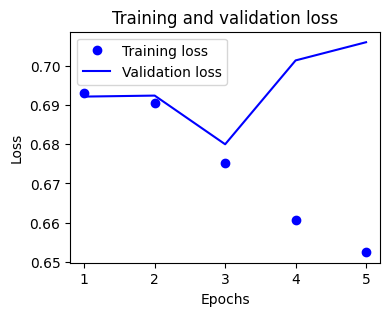

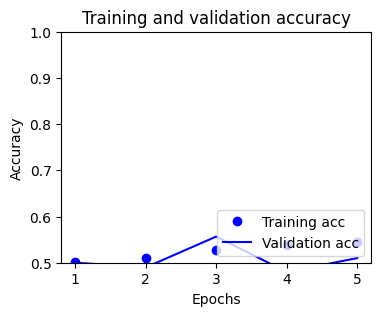

In [6]:
# 코드 8-19 훈련 결과 시각화
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_batches.shuffle(BUFFER_SIZE)
import matplotlib.pyplot as plt

history_dict = history.history  # 학습 이력 정보를 history_dict에 저장
acc = history_dict["accuracy"]  # history_dict에 저장된 ‘accuracy’ 데이터를 acc에 저장
# history_dict에 저장된 ‘val_accuracy’ 데이터를 val_acc에 저장
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]  # history_dict에 저장된 ‘loss’ 데이터를 loss에 저장
# history_dict에 저장된 ‘val_loss’ 데이터를 val_loss에 저장
val_loss = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)  # 에포크 지정 ------ (1~acc의 길이 ------ +1)
# figure는 그래프 크기를 지칭하는 것으로, 가로 4인치, 세로 3인치로 지정
plt.figure(figsize=(4, 3))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim((0.5, 1))
plt.show()

In [14]:
# 코드 8-20 드롭아웃이 적용된 모델
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, 64),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=True)
        ),  # LSTM 대신 양방향 RNN 사용
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.5),  # 드롭아웃 적용
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 코드 8-21 모델 컴파일
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)
history = model.fit(
    train_batches, epochs=5, validation_data=test_batches, validation_steps=30
)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 506s 201ms/step - accuracy: 0.5865 - loss: 0.6455 - val_accuracy: 0.7833 - val_loss: 0.4780
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 499s 200ms/step - accuracy: 0.8480 - loss: 0.3825 - val_accuracy: 0.8067 - val_loss: 0.4345
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 520s 208ms/step - accuracy: 0.8874 - loss: 0.2990 - val_accuracy: 0.8833 - val_loss: 0.2832
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 502s 201ms/step - accuracy: 0.9089 - loss: 0.2540 - val_accuracy: 0.8733 - val_loss: 0.3058
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 497s 199ms/step - accuracy: 0.9254 - loss: 0.2163 - val_accuracy: 0.8700 - val_loss: 0.3736


2024-11-26 15:27:19.040071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


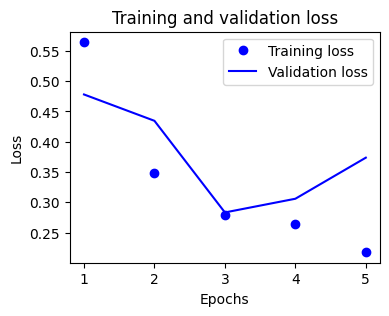

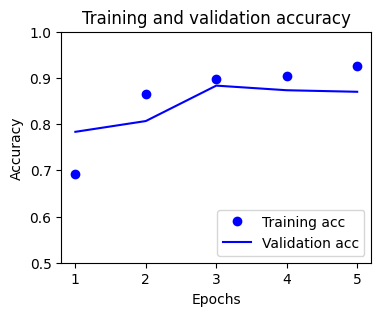

In [9]:
# 코드 8-22 훈련에 대한 시각화
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_batches.shuffle(BUFFER_SIZE)
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(4, 3))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim((0.5, 1))
plt.show()

In [10]:
# 코드 8-23 양방향 RNN만 적용한 모델
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(encoder.vocab_size, 64),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 코드 8-24 모델 훈련
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"],
)
history = model.fit(
    train_batches, epochs=5, validation_data=test_batches, validation_steps=30
)

Epoch 1/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 263s 104ms/step - accuracy: 0.6161 - loss: 0.6122 - val_accuracy: 0.8533 - val_loss: 0.3621
Epoch 2/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 257s 103ms/step - accuracy: 0.8764 - loss: 0.3126 - val_accuracy: 0.8600 - val_loss: 0.3662
Epoch 3/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 266s 106ms/step - accuracy: 0.9054 - loss: 0.2585 - val_accuracy: 0.8567 - val_loss: 0.4098
Epoch 4/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 266s 106ms/step - accuracy: 0.9214 - loss: 0.2170 - val_accuracy: 0.8300 - val_loss: 0.4333
Epoch 5/5
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 257s 103ms/step - accuracy: 0.9347 - loss: 0.1899 - val_accuracy: 0.8633 - val_loss: 0.4423


2024-11-26 15:49:07.430723: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


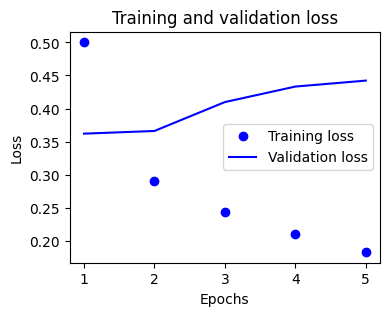

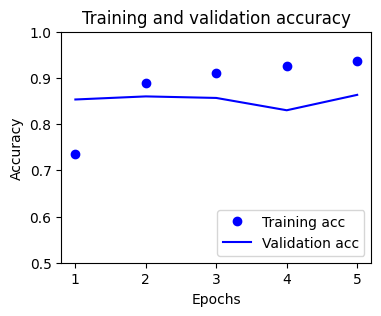

In [12]:
# 코드 8-25 모델 훈련에 대한 시각화
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_batches.shuffle(BUFFER_SIZE)
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(4, 3))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(4, 3))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim((0.5, 1))
plt.show()